# Practice Pytorch by using pytorch document

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

### Load the data to train and test

In [2]:
training_data = datasets.FashionMNIST(root = 'data', download=True, train=True, transform= ToTensor())

test_data = datasets.FashionMNIST(root = 'data', download=True, train=False, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:08<00:00, 2982214.36it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 96032.17it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1404144.65it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7364350.95it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Make a dataloader for batch

shape of the X : torch.Size([64, 1, 28, 28])
shape of the y : torch.Size([64]) torch.int64
The smaple of the y : tensor([0, 2, 4, 7, 0, 6, 6, 9, 0, 3, 5, 6, 3, 6, 7, 8, 3, 2, 4, 5, 3, 9, 0, 0,
        0, 3, 2, 1, 8, 1, 4, 0, 5, 2, 3, 4, 3, 9, 8, 2, 8, 9, 7, 9, 3, 3, 7, 1,
        4, 4, 8, 8, 4, 3, 0, 8, 9, 6, 8, 7, 3, 3, 2, 3])


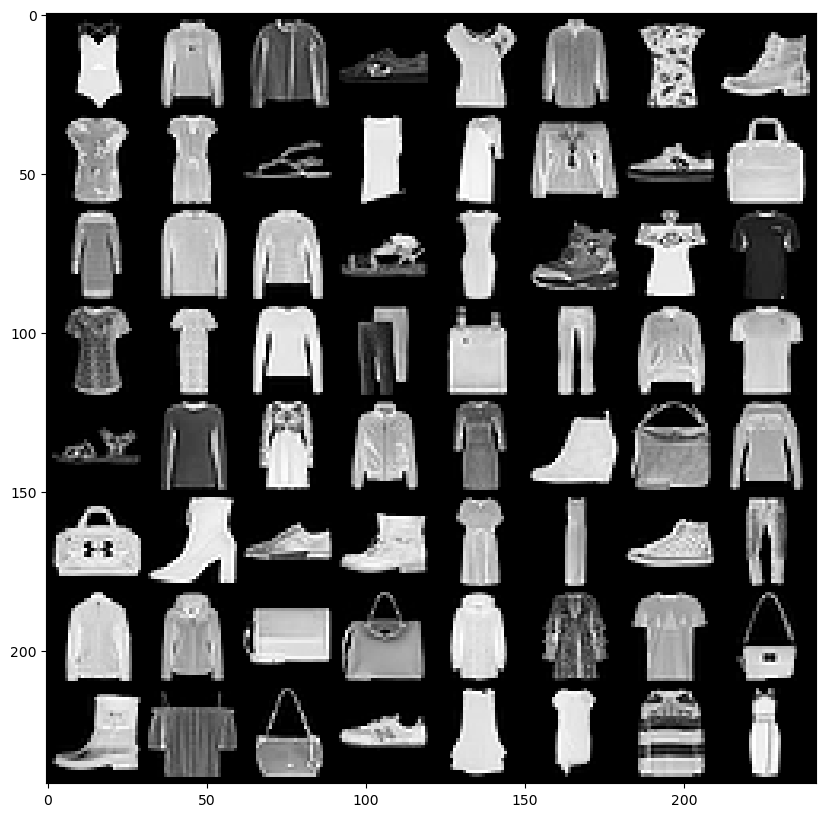

In [ ]:
import matplotlib.pyplot as plt 
from torchvision.utils import make_grid
import numpy as np

batch_size = 64

train_dataloader = DataLoader(training_data, shuffle = True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size=batch_size)

for X, y in test_dataloader:
    print(f'shape of the X : {X.shape}')
    print(f'shape of the y : {y.shape} {y.dtype}')
    grid_image = make_grid(X, nrow = 8) # torchvision에서 제공하는 라이브러리로, 이미지를 grid 형식으로 정렬해준다.
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid_image.cpu().numpy(), (1,2,0))) # 이미지를 cpu, numpy 형식으로 변형한 후 시각화 해준다.
    print(f'The smaple of the y : {y}')
    break

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device : {device}')

Using device : mps


### Make a simple model

In [5]:
# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 손실함수와 최적화 함수를 선언합니다.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # 전체 데이터의 개수를 반환합니다.
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad() # 최적화 가중치들을 초기화 합니다.
        pred = model(X) 
        loss = loss_fn(pred, y)

        loss.backward() # 손실을 통해서 역전파를 진행합니다. 
        optimizer.step() # 가중치를 최적화 방법에 따라 업데이트 시킵니다.

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # 총 데이터의 갯수르 의미한다.
    num_batches = len(dataloader) # 총 몇개의 batch가 존재하는지를 의미한다.
    model.eval() 
    test_loss, correct = 0, 0
    with torch.no_grad(): # 가중치 업데이트를 하지 않도록 설정한다.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            '''
             pred는 보통 [ batch_size, class수 ] 로 구성됩니다. 그래서 각각의 샘플마다 가장 높은 확률 값을 갖는 클래스의 인덱스를 
             얻기 위해서는 1차원 데이터를 사용해야하기에 pred.argmax(1)을 사용하게 됩니다.
            '''
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306527  [   64/60000]
loss: 2.292343  [ 6464/60000]
loss: 2.273023  [12864/60000]
loss: 2.256910  [19264/60000]
loss: 2.260283  [25664/60000]
loss: 2.220712  [32064/60000]
loss: 2.225638  [38464/60000]
loss: 2.205202  [44864/60000]
loss: 2.196849  [51264/60000]
loss: 2.196096  [57664/60000]
Test Error: 
 Accuracy: 38.3%, Avg loss: 2.173383 

Epoch 2
-------------------------------
loss: 2.155195  [   64/60000]
loss: 2.136370  [ 6464/60000]
loss: 2.134796  [12864/60000]
loss: 2.157539  [19264/60000]
loss: 2.106914  [25664/60000]
loss: 2.076315  [32064/60000]
loss: 2.054816  [38464/60000]
loss: 1.971763  [44864/60000]
loss: 1.965449  [51264/60000]
loss: 1.935633  [57664/60000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.930509 

Epoch 3
-------------------------------
loss: 1.932907  [   64/60000]
loss: 1.840770  [ 6464/60000]
loss: 1.870005  [12864/60000]
loss: 1.812759  [19264/60000]
loss: 1.799555  [25664/60000]
loss: 1.743884  [32064/600